In [283]:
import json
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import pandas as pd
from loguru import logger
import matplotlib.pyplot as plt
from matplotlib import rcParams

# 设置字体为 Microsoft YaHei（微軟正黑體）

rcParams["font.sans-serif"] = ["Microsoft YaHei"]
rcParams["axes.unicode_minus"] = False  # 解决负号显示问题

In [284]:
# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用的设备：{device}")

使用的设备：cuda


In [285]:
df = pd.read_csv(r"../../../../csv/房價_add南科and股價.csv")

# 讀取資料
df["交易年月日"] = pd.to_datetime(df["交易年月日"])
df = df.sort_values("交易年月日")

# 處理時間特徵
df["time_diff"] = df["交易年月日"].diff().dt.days.fillna(0)
df["cumulative_time"] = (df["交易年月日"] - df["交易年月日"].min()).dt.days

# 只取Region = A區域
# df = df[df["Region"] == "A"]

# df = df.dropna()

df.shape

C:\Users\student\AppData\Local\Temp\ipykernel_14972\2982623015.py:1: DtypeWarning: Columns (37) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


(201010, 121)

In [286]:
# 數值特徵
numerical_features = [
    "單價元每坪",
    "建物移轉總面積平方公尺",
    "time_diff",
    "cumulative_time",
    "建物現況格局-房",
    "建物現況格局-廳",
    "建物現況格局-衛",
    "建物現況格局-隔間",
    "屋齡",
    # "營業額總計",
    "stockTW",
    "KDE_0.5km",
    "KDE_1km",
    "KDE_1.5km",
    # "KDE_class",
    "good_count_0_500",
    "good_count_500_1000",
    "good_count_1000_1500",
    "bad_count_0_500",
    "bad_count_500_1000",
    "bad_count_1000_1500",
]

# one-hot特徵
one_hot_features = [
    "建築型態_住商大樓",
    "建築型態_公寓",
    "建築型態_其他",
    "建築型態_透天厝",
    "是否包含車位",
    "建材_磚石",
    "建材_鋼筋",
    "建材_鋼骨",
    "建材_竹木",
    "住",
    "商",
    "工",
    "農",
    "移轉層次_騎樓",
    "移轉層次_屋頂",
    "移轉層次_一二樓",
    "鄉鎮_七股區",
    "鄉鎮_下營區",
    "鄉鎮_中西區",
    "鄉鎮_仁德區",
    "鄉鎮_佳里區",
    "鄉鎮_六甲區",
    "鄉鎮_北區",
    "鄉鎮_北門區",
    "鄉鎮_南化區",
    "鄉鎮_南區",
    "鄉鎮_善化區",
    "鄉鎮_大內區",
    "鄉鎮_學甲區",
    "鄉鎮_安南區",
    "鄉鎮_安定區",
    "鄉鎮_安平區",
    "鄉鎮_官田區",
    "鄉鎮_將軍區",
    "鄉鎮_山上區",
    "鄉鎮_左鎮區",
    "鄉鎮_後壁區",
    "鄉鎮_新化區",
    "鄉鎮_新市區",
    "鄉鎮_新營區",
    "鄉鎮_東區",
    "鄉鎮_東山區",
    "鄉鎮_柳營區",
    "鄉鎮_楠西區",
    "鄉鎮_歸仁區",
    "鄉鎮_永康區",
    "鄉鎮_玉井區",
    "鄉鎮_白河區",
    "鄉鎮_西港區",
    "鄉鎮_關廟區",
    "鄉鎮_鹽水區",
    "鄉鎮_麻豆區",
    "鄉鎮_龍崎區",
]

# 目標變數
target_feature = ["單價元每坪"]

# 取出數值特徵，並轉換為 PyTorch 張量
numerical_data = df[numerical_features].values  # (N, num_features)
numerical_tensor = torch.FloatTensor(numerical_data)  # 轉換為 PyTorch 張量

one_hot_data = df[one_hot_features].values
one_hot_tensor = torch.FloatTensor(one_hot_data)

# 打印結果，確認形狀是否正確
print(one_hot_tensor.shape)
print(numerical_tensor.shape)

torch.Size([201010, 53])
torch.Size([201010, 19])


In [287]:
def create_time_window_sequences(
    numerical_features, one_hot_features, target, window_size, step=1
):
    sequences, targets = [], []

    # 提取每坪單價（假設這是 numerical_features 的第一列）
    unit_price = numerical_features[:, 0].reshape(-1, 1)  # 每坪單價（目標變數的一部分）
    other_features = numerical_features[:, 1:]  # 其他數值特徵

    # 逐步創建時間窗口
    for i in range(0, len(other_features) - window_size, step):
        # 提取過去 window_size 筆的數值特徵和歷史房價
        num_features_window = other_features[i : i + window_size]
        unit_price_window = unit_price[i : i + window_size]

        # 提取對應的 One-Hot 特徵（前 30 筆）
        one_hot_window = one_hot_features[i : i + window_size]

        # 將數值特徵、房價和 One-Hot 特徵拼接為一個窗口
        combined_window = np.hstack(
            [num_features_window, unit_price_window, one_hot_window]
        )

        # 提取第 31 筆資料的特徵
        next_num_feature = other_features[i + window_size]
        # next_unit_price = unit_price[i + window_size]
        next_one_hot_feature = one_hot_features[i + window_size]
        # 初始化第31天房價=0
        next_unit_price = 0

        # 拼接第 31 筆的特徵
        next_combined = np.hstack(
            [next_num_feature, next_unit_price, next_one_hot_feature]
        )

        # 將第 31 筆資料與前 30 筆資料拼接
        full_window = np.vstack([combined_window, next_combined])

        # 將拼接後的完整窗口添加到序列
        sequences.append(full_window)

        # 將第 31 筆的房價作為目標
        targets.append(target[i + window_size])

    # 將序列和目標轉換為 NumPy 陣列
    sequences = np.array(sequences)  # [num_samples, seq_length + 1, num_features]
    targets = np.array(targets)

    return sequences, targets

In [288]:
# 使用新的时间窗口函数来创建数据集
X, y = create_time_window_sequences(
    numerical_data,  # 数值特征
    one_hot_data,  # One-Hot 编码特征
    df[target_feature].values,  # 目标变量（房价）
    window_size=30,  # 时间窗口大小为 30
    step=15,  # 步长为 15
)


_, _, num_features = X.shape  # 确保 X 的形状：[batch_size, num_features, seq_length]


# 将 X 展平成 2D 以计算均值和标准差

_X = X.reshape(-1, num_features)  # shape: [batch_size * seq_length, num_features]


# 计算每个特征维度的均值和标准差

x_mean = _X.mean(axis=0)[np.newaxis, np.newaxis, ...]  # shape: [1, 1, num_features]

x_std = _X.std(axis=0)[np.newaxis, np.newaxis, ...]  # shape: [1, 1, num_features]


# 对 X 进行标准化

X = (X - x_mean) / x_std


# 对目标变量 y 进行标准化

y = (y - y.mean(axis=0)) / y.std(axis=0)


# 打印 X 和 y 的形状

logger.info(f"x shape= {X.shape}")  # 预期: [batch_size, num_features, seq_length]

logger.info(f"y shape= {y.shape}")  # 预期: [batch_size,]


# === 拆分训练集和测试集 ===

test_size = int(0.2 * len(X))

X_train, X_test = X[:-test_size], X[-test_size:]

y_train, y_test = y[:-test_size], y[-test_size:]


X = np.nan_to_num(X, nan=0.0)  # 将 NaN 转换为 0
y = np.nan_to_num(y, nan=0.0)



# 转换为 PyTorch 张量

X_train_tensor = torch.FloatTensor(X_train)

y_train_tensor = torch.FloatTensor(y_train)

X_test_tensor = torch.FloatTensor(X_test)

y_test_tensor = torch.FloatTensor(y_test)

# print(torch.isnan(X_train_tensor).sum())  # 检查是否有 NaN
# print(torch.isnan(X_test_tensor).sum())  # 检查是否有 NaN
# print(torch.isnan(y_train_tensor).sum())  # 检查是否有 NaN
# print(torch.isnan(y_test_tensor).sum())  # 检查是否有 NaN


# 打印形状以确认正确性

print(X_train.shape)  # 预期: [train_size, num_features, seq_length]
print(X_test.shape)  # 预期: [test_size, num_features, seq_length]

print(y_train.shape)  # 预期: [train_size,]
print(y_test.shape)  # 预期: [test_size,]


print(X_train_tensor.shape)  # 检查 PyTorch 张量的形状

2024-10-27 14:27:59.813 | INFO     | __main__:<module>:26 - x shape= (13399, 31, 72)
2024-10-27 14:27:59.814 | INFO     | __main__:<module>:27 - y shape= (13399, 1)


(10720, 31, 72)
(2679, 31, 72)
(10720, 1)
(2679, 1)
torch.Size([10720, 31, 72])


In [289]:
print(np.isnan(X).sum(), np.isinf(X).sum())  # 检查 X 中的 NaN 和 Inf
print(np.isnan(y).sum(), np.isinf(y).sum())  # 检查 y 中的 NaN 和 Inf

0 0
0 0


In [290]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # === 定義全連接層（前置 Dense 層）===
        # self.pre_dense1 = nn.Linear(input_dim, 128)  # 將輸入維度轉為 128
        # self.pre_dense2 = nn.Linear(128, 64)  # 將 128 維轉為 64 維
        # self.pre_dense_activation = nn.GELU()  # 激活函數
        # self.dropout = nn.Dropout(dropout)  # Dropout

        # === 定義 LSTM 層 ===
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )

        # === 定義後續的全連接層 ===
        # self.fc1 = nn.Linear(hidden_dim*31, 8)
        self.fc1 = nn.Linear(hidden_dim, 8)
        # self.bn1 = nn.BatchNorm1d(32)
        self.fc2 = nn.Linear(8, 4)
        # self.bn2 = nn.BatchNorm1d(8)
        self.fc3 = nn.Linear(4, output_dim)

        # 激活函數
        self.gelu = nn.GELU()
        self.tahn = nn.Tanh()
        self.flatten = nn.Flatten()

    def forward(self, x):
        # === 通過 Dense 層處理輸入 ===
        # out = self.pre_dense1(x)
        # out = self.pre_dense_activation(out)
        # out = self.dropout(out)

        # out = self.pre_dense2(out)
        # out = self.pre_dense_activation(out)
        # out = self.dropout(out)

        # 初始化 LSTM 的隱藏狀態和細胞狀態
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        # === 前向傳播 LSTM ===
        out, _ = self.lstm(
            x, (h0, c0)
        )  # LSTM 層輸入形狀 (batch_size, time_steps, input_size)
        out = out[:, -1, :]  # 取最後一個時間步的輸出
        # out = self.flatten(out)
        # out = out.reshape(out.size(0), -1)

        # === 通過後續的全連接層 ===
        out = self.tahn(self.fc1(out))
        out = self.gelu(self.fc2(out))
        out = self.fc3(out)

        return out


def train_model(
    model,
    optimizer,
    criterion,
    train_loader,
    val_loader,
    scheduler,
    # scaler,
    num_epochs=50,
    patience=10,
):
    best_val_loss = float("inf")
    trigger_times = 0

    # 用于记录每个 epoch 的损失
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # === Training Phase ===
        model.train()
        epoch_train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            # with torch.amp.autocast(device_type=device.type):
            # print(X_batch.shape)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            loss.backward()
            # scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            # scaler.step(optimizer)
            # scaler.update()
            optimizer.step()

            epoch_train_loss += loss.item() * X_batch.size(0)

        avg_train_loss = epoch_train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)  # 记录训练损失

        # === Validation Phase ===
        model.eval()
        epoch_val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                epoch_val_loss += loss.item() * X_batch.size(0)

        avg_val_loss = epoch_val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)  # 记录验证损失

        scheduler.step(avg_val_loss)

        logger.info(
            f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}"
        )

        # # === 保存最佳模型 ===
        # if avg_val_loss < best_val_loss:
        #     best_val_loss = avg_val_loss
        #     trigger_times = 0  # 重置计数器
        #     torch.save(model.state_dict(), "best_model.pth")
        #     print(f"保存最佳模型: Epoch {epoch + 1}, Val Loss: {avg_val_loss:.6f}")
        # else:
        #     trigger_times += 1
        #     if trigger_times >= patience:
        #         print("Early stopping triggered!")
        #         break

    # 返回 3 个值：验证损失、训练损失列表、验证损失列表
    return best_val_loss, train_losses, val_losses


def plot_loss_curve(train_losses, val_losses):
    """绘制训练和验证损失曲线"""
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Curve")
    plt.legend()
    plt.show()

In [291]:
print(X_train.shape[1:])

(31, 72)


In [292]:
# 提取最佳超参数组合
best_params = {
    "hidden_dim": 64,
    "num_layers": 2,
    "dropout": 0.1,
    "learning_rate": 1e-4,
    "weight_decay": 1e-5,
    "batch_size": 8,
}
# print(f"最佳超参数组合: {best_params}")

# 使用最佳超参数组合初始化模型
model = LSTMModel(
    input_dim=X_train.shape[2],
    hidden_dim=best_params["hidden_dim"],
    num_layers=best_params["num_layers"],
    output_dim=1,
    dropout=best_params["dropout"],
).to(device)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=best_params["learning_rate"],
    weight_decay=best_params["weight_decay"],
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=10
)


# 数据加载器，使用最佳批量大小
train_loader = DataLoader(
    TensorDataset(X_train_tensor, y_train_tensor),
    batch_size=best_params["batch_size"],
    shuffle=True,
)
val_loader = DataLoader(
    TensorDataset(X_test_tensor, y_test_tensor),
    batch_size=best_params["batch_size"],
    shuffle=False,
)

In [293]:
# from torchvision import models
# from torchsummary import summary

# summary(model, (41,))

2024-10-27 14:28:03.885 | INFO     | __main__:train_model:123 - Epoch 1/50, Train Loss: 0.530859, Val Loss: 1.493866
2024-10-27 14:28:07.609 | INFO     | __main__:train_model:123 - Epoch 2/50, Train Loss: 0.431492, Val Loss: 1.301262
2024-10-27 14:28:11.375 | INFO     | __main__:train_model:123 - Epoch 3/50, Train Loss: 0.339351, Val Loss: 1.136641
2024-10-27 14:28:15.238 | INFO     | __main__:train_model:123 - Epoch 4/50, Train Loss: 0.306691, Val Loss: 0.959769
2024-10-27 14:28:18.992 | INFO     | __main__:train_model:123 - Epoch 5/50, Train Loss: 0.293025, Val Loss: 0.905886
2024-10-27 14:28:22.801 | INFO     | __main__:train_model:123 - Epoch 6/50, Train Loss: 0.280200, Val Loss: 0.854739
2024-10-27 14:28:27.073 | INFO     | __main__:train_model:123 - Epoch 7/50, Train Loss: 0.271603, Val Loss: 0.859113
2024-10-27 14:28:31.562 | INFO     | __main__:train_model:123 - Epoch 8/50, Train Loss: 0.263419, Val Loss: 0.797203
2024-10-27 14:28:35.918 | INFO     | __main__:train_model:123 - 

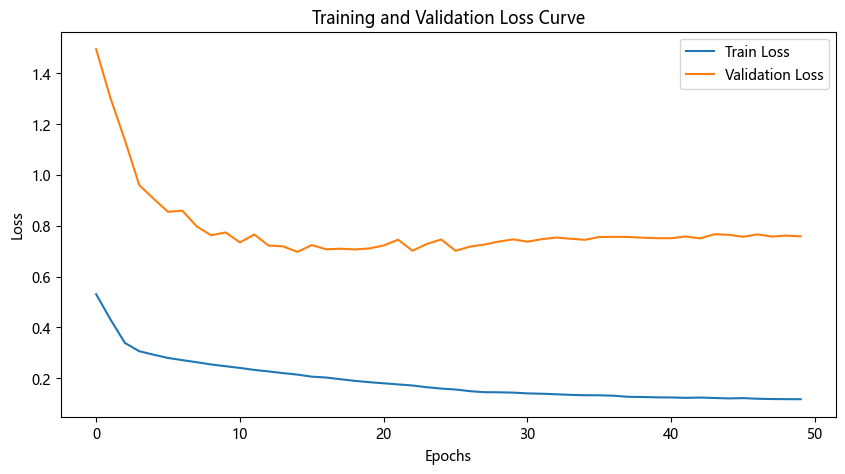

In [294]:
# 重新训练模型并记录损失
best_val_loss, train_losses, val_losses = train_model(
    model,
    optimizer,
    nn.MSELoss(),
    train_loader,
    val_loader,
    scheduler,
    # scaler,
    num_epochs=50,
)

# print(f"最佳模型的验证损失: {best_val_loss}")

# 绘制训练和验证损失曲线
plot_loss_curve(train_losses, val_losses)

Train_MAE: 0.2215130776166916
Train_R²: 0.8464006185531616
Test_MAE: 0.6845000386238098
Test_R²: 0.3161275386810303


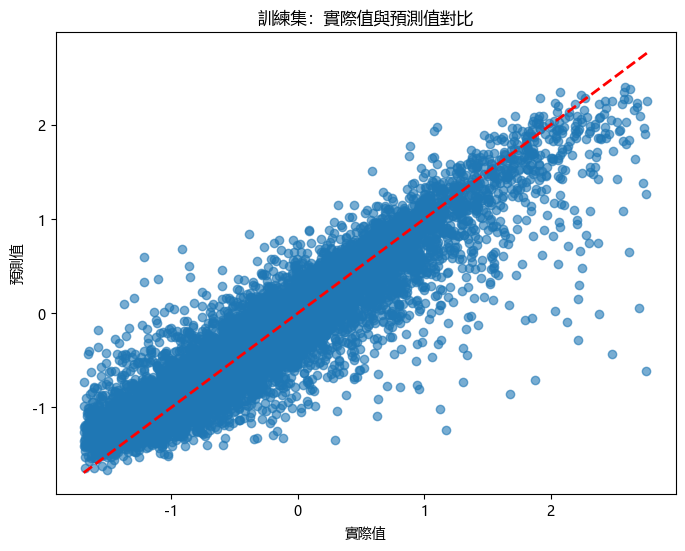

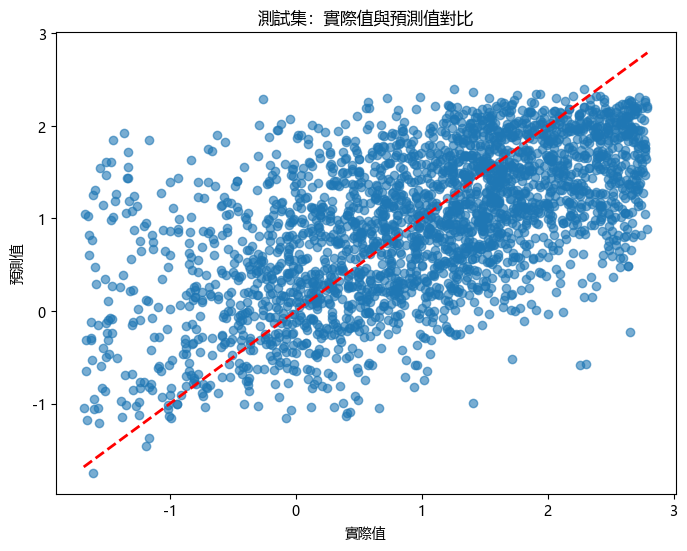

In [295]:
def evaluate_in_batches(model, X_tensor, y_tensor, batch_size=16):
    """逐批评估并返回所有预测和真实值"""
    model.eval()  # 设置为评估模式
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for i in range(0, len(X_tensor), batch_size):
            X_batch = X_tensor[i : i + batch_size].to(device)
            y_batch = y_tensor[i : i + batch_size].to(device)

            # 获取模型的预测结果
            predictions = model(X_batch)
            all_predictions.append(predictions.cpu())  # 移回 CPU 并存储
            all_targets.append(y_batch.cpu())  # 真实标签也移回 CPU

    # 将所有批次的预测结果和真实标签拼接成完整的数组
    all_predictions = torch.cat(all_predictions).numpy()
    all_targets = torch.cat(all_targets).numpy()

    return all_predictions, all_targets


# === 评估训练集 ===
train_predictions, train_targets = evaluate_in_batches(
    model, X_train_tensor, y_train_tensor
)

# === 评估测试集 ===
test_predictions, test_targets = evaluate_in_batches(
    model, X_test_tensor, y_test_tensor
)

# === 计算 MAE 和 R² 分数 ===

# 训练集上的评估指标
train_mae = mean_absolute_error(train_targets, train_predictions)
train_r2 = r2_score(train_targets, train_predictions)
print(f"Train_MAE: {train_mae}")
print(f"Train_R²: {train_r2}")

# 测试集上的评估指标
test_mae = mean_absolute_error(test_targets, test_predictions)
test_r2 = r2_score(test_targets, test_predictions)
print(f"Test_MAE: {test_mae}")
print(f"Test_R²: {test_r2}")


# === 可视化函数：训练集和测试集 ===
def plot_predictions(true_values, predictions, title="實際值與預測值對比"):
    """可视化预测值与真实值的对比"""
    plt.figure(figsize=(8, 6))
    plt.scatter(true_values, predictions, alpha=0.6)
    plt.plot(
        [true_values.min(), true_values.max()],
        [true_values.min(), true_values.max()],
        "r--",
        lw=2,
    )  # y=x 参考线
    plt.xlabel("實際值")
    plt.ylabel("預測值")
    plt.title(title)
    plt.show()


# === 可视化训练集 ===
plot_predictions(train_targets, train_predictions, title="訓練集：實際值與預測值對比")

# === 可视化测试集 ===
plot_predictions(test_targets, test_predictions, title="測試集：實際值與預測值對比")